First, let's install the OpenAI gym and Atari environment:

In [1]:
!pip install gym gym[atari]

Let's import the needed libraries

In [1]:
import gym, time
import matplotlib.pyplot as plt
import numpy as np
from skimage import color

Now, let's import Keras for our model later

In [2]:
from keras.layers import Input, Flatten, Dense, Concatenate, Multiply, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import RMSprop

Using TensorFlow backend.


# Cartpole example

This example shows how to use an OpenAI gym environment.
First, we choose and init the environment:

In [3]:
env = gym.make('CartPole-v0')
env.reset()

array([0.02809307, 0.02559229, 0.03536608, 0.03344944])

Then we iterate for a big number of times. Each time, we do the following:
* Render the environment
* Get the observation, the reward and the `done` variable (it indicates whether we lost or not
* (Optional) Sleep for 20ms, makes the animation smoother
* (Optional) If we lost (`done == True`), reset the environment
    

In [5]:
for _ in range(50):
    env.render()
    obs, rew, done, info = env.step(env.action_space.sample()) # take a random action
    time.sleep(0.02)
    # Comment the two following lines to see cases of "failure"
    #if done:
    #   env.reset()
env.close()

`obs` is an array of length 4, whose values are: <br/>
`[position of cart, velocity of cart, angle of pole, rotation rate of pole]`

# BattleZone environment


Actually, there are 12 environments. The main difference is the observation type:
* The "normal" environments: observations are the frames of the game. They are bigger and more complex to analyse, but more intuitive.
* The RAM environments: observations are a 128-byte arrays, representing the RAM of the Atari console. Lighter to use, but we do not know what each byte represents.

The environment is provided in binary so we cannot modify it. Besides, it is hard to replicate the logic behind the spawning of enemies, so we chose to use the OpenAI environments directly.

In [3]:
battlezone_envs = ['BattleZone-v0', 
        'BattleZone-v4',
        'BattleZoneDeterministic-v0', 
        'BattleZoneDeterministic-v4', 
        'BattleZoneNoFrameskip-v0', 
        'BattleZoneNoFrameskip-v4',
        'BattleZone-ram-v0',
        'BattleZone-ram-v4',
        'BattleZone-ramDeterministic-v0', 
        'BattleZone-ramDeterministic-v4', 
        'BattleZone-ramNoFrameskip-v0',
        'BattleZone-ramNoFrameskip-v4']

## Normal environment:

In [4]:
env_number = 0
env = gym.make(battlezone_envs[env_number])

env.reset()
for _ in range(2000):
    env.render()
    obs, rew, done, info = env.step(env.action_space.sample()) # take a random action
    time.sleep(0.02)
env.close()

In [5]:
obs.shape

(210, 160, 3)

### Preprocessing

We try to get the dimensions of the interesting parts of the observation:
* The radar part (that is in the top middle part of the frame)
* The view from the tank's cockpit, restrained to the green field (and a little of the background mountains) which will contain the moving enemies as well as the projectiles' range and most importantly the cursor indicating what is directly in front of our tank

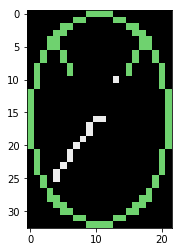

In [6]:
plt.imshow(obs[3:36,74:96])

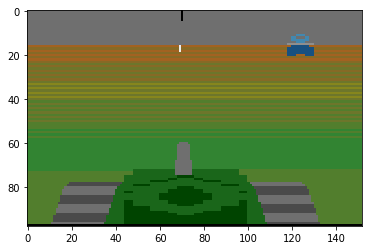

In [7]:
plt.imshow(obs[80:178,8:])

In [8]:
def to_gray(img):
    # Convert images to grayscale with values between 0 and 1
    return color.rgb2gray(img).astype(np.float32)

In [9]:
def downsample(img):
    # Downsampling an image for faster computing
    return img[::2, ::2]

In [10]:
def preprocessing(obs):
    radar = obs[3:36,74:96]
    scene = obs[80:178,8:]
    radar = to_gray(radar)
    scene = downsample(to_gray(scene))
    return radar, scene

In [11]:
radar, scene = preprocessing(obs)

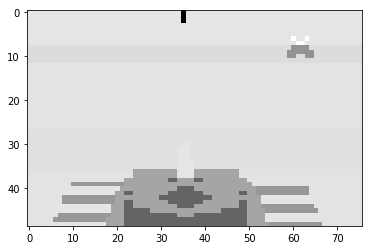

In [12]:
plt.imshow(scene, cmap="gray")

In [13]:
print(radar.shape, scene.shape)

(33, 22) (49, 76)


#### Agent

We will be giving the model a number of frames at a time (the time of the last projectile sent can be a determining factor, so the agent may need it)

In [14]:
n_frames = 2 #Number of input frames per input
n_actions = 18 #Dimension of action space
batch_size = 32 #Number of entries (states+actions) to feed the NN
memory_size = 100000 # Memory size for experience replay

We will use a Huber loss function for our model to prevent heavy penalization of high errors (linear instead of quadratic). We will implement the function so it can be used within a Keras neural network

In [15]:
from keras import backend as K

def huber_loss(a, b):
    e = a - b
    quad = e**2 / 2
    lin = abs(e) - 1/2
    use_lin = (abs(e) > 1.0)
    use_lin = K.cast(use_lin, 'float32')
    return use_lin * lin + ( 1 - use_lin) * quad

In [16]:
def sample_net():
     # Shapes of entries
    scene_shape = (49, 76, n_frames) # We will be using the number of frames as the number of channels 
    radar_shape = (33,22, n_frames)
    
    # Input layers
    scene_inp = Input(shape=scene_shape, name='scenes')#, batch_shape=(n_frames, 49, 76))
    radar_inp = Input(shape=radar_shape, name='radars')#, batch_shape=(n_frames, 33, 22))
    actions_inp = Input((n_actions,), name='actions')
    
    # First convolution layers
    conv1_1 = Conv2D(filters=8, kernel_size=(8, 8), strides=(4, 4), activation='relu', data_format="channels_last")(scene_inp)
    conv2_1 = Conv2D(filters=8, kernel_size=(4, 4), strides=(2, 2), activation='relu', data_format="channels_last")(radar_inp)
    
    # First maxpooling attempt
    maxpool1_1 = MaxPooling2D(pool_size=(8, 8), strides=(4, 4))(conv1_1)
    maxpool2_1 = MaxPooling2D(pool_size=(4, 4), strides=(2, 2))(conv2_1)
    
    # Flattening results
    flattened_1 = Flatten()(maxpool1_1)
    flattened_2 = Flatten()(maxpool2_1)
    
    # Concatenating the results of the two entries
    concat = Concatenate(axis=1)([flattened_1, flattened_2])
    
    # Output layer
    output = Dense(n_actions, activation='softmax')(concat)
    
    # Multiply by the actions
    filtered_output = Multiply()([output, actions_inp])
    
    # Creating the model
    model = Model(input=[scene_inp, radar_inp, actions_inp], 
                  output=filtered_output,
                 )
    
    # Optimizer choice and tuning
    rms = RMSprop(lr = 0.00025)
    
    # Compiling
    model.compile(optimizer=rms, loss=huber_loss)
    
    return model
    

In [17]:
def nor_env_net():
    
    # Shapes of entries
    scene_shape = (49, 76, n_frames) # We will be using the number of frames as the number of channels 
    radar_shape = (33,22, n_frames)
    
    # Input layers
    scene_inp = Input(scene_shape, name='scenes')#, batch_shape=(4, 49, 76))
    radar_inp = Input(radar_shape, name='radars')#, batch_shape=(4, 33, 22))
    actions_inp = Input((n_actions,), name='actions')
    
    # First convolution layers
    conv1_1 = Conv2D(filters=16, kernel_size=(8, 8), strides=(4, 4), activation='relu')(scene_inp)
    conv2_1 = Conv2D(filters=16, kernel_size=(4, 4), strides=(2, 2), activation='relu')(radar_inp)
    
    # First maxpooling attempt
    # maxpool1_1 = MaxPooling2D(pool_size=(8, 8), strides=(4, 4))(conv1_1)
    # maxpool2_1 = MaxPooling2D(pool_size=(4, 4), strides=(2, 2))(conv2_1)
    
    # Second convolutional layers
    conv1_2 = Conv2D(filters=32, kernel_size=(4, 4), strides=(2, 2), activation='relu')(conv1_1)
    conv2_2 = Conv2D(filters=32, kernel_size=(2, 2), strides=(1, 1), activation='relu')(conv2_1)
    
    # Second maxpooling attempt
    maxpool1_2 = MaxPooling2D(pool_size=(4, 4), strides=(2, 2))(conv1_2)
    maxpool2_2 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(conv2_2)
    
    # Flattening results
    flattened_1 = Flatten('channels_first')(maxpool1_2)
    flattened_2 = Flatten('channels_first')(maxpool2_2)
    
    # Concatenating the results of the two entries
    concat = Concatenate(axis=1)([flattened_1, flattened_2])
    
    # Applying a fully-connected layer
    hidden_layer = Dense(256, activation='relu')(concat)
    
    # Output layer
    output = Dense(n_actions, activation='softmax')(hidden_layer)
    
    # Multiply by the actions
    filtered_output = Multiply()([output, actions_inp])
    
    # Creating the model
    model = Model(input=[scene_inp, radar_inp, actions_inp], 
                  output=filtered_output,
                 )
    
    # Optimizer choice and tuning
    rms = RMSprop(lr = 0.00025)
    
    # Compiling
    model.compile(optimizer=rms, loss=huber_loss)
    
    return model

In [18]:
def radar_exclusive():
    
    # Shape of entries
    radar_shape = (n_frames, 33*22,) # Since we will be using a fully connected network here,
                                    # we will provide a flattened version of the radar frame
    
    # Input layers
    radar_inp = Input(shape=radar_shape, name='radars')#, batch_shape=(n_frames, 33, 22))
    actions_inp = Input((n_actions,), name='actions')
    
    # Hidden layers
    hid1 = Dense(512, activation="relu")(radar_inp)
    hid2 = Dense(256, activation="relu")(hid1)
    
    # Output
    output = Dense(n_actions, activation='softmax')(hid2)
    
    # Multiply by the actions
    filtered_output = Multiply()([output, actions_inp])
    
    # Creating the model
    model = Model(input=[radar_inp, actions_inp], 
                  output=filtered_output,
                 )
    
    # Optimizer choice and tuning
    rms = RMSprop(lr = 0.00025)
    
    # Compiling
    model.compile(optimizer=rms, loss=huber_loss)
    
    return model
    

In [51]:
from keras.utils import plot_model
#model = nor_env_net()
#model = sample_net()
#model= radar_exclusive()
plot_model(model,
           to_file='model.png',
           show_shapes=True)

In [19]:
scenes = list()
radars = list()
radar, scene = preprocessing(obs)

for i in range(n_frames):
    radars.append(radar)
    scenes.append(scene)

In [20]:
s1 = (len(radars), radar.shape[0], radar.shape[1])
s2 = (len(scenes), scene.shape[0], scene.shape[1])
print(s1)
print(s2)

(2, 33, 22)
(2, 49, 76)


In [21]:
scenes[0][0]

array([0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.        , 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529412,
       0.43529412, 0.43529412, 0.43529412, 0.43529412, 0.43529

In [22]:
"""for i in range(s1[0]):
    for j in range(s1[1]):
        for k in range(s1[2]):
            radars_array[i,j,k] = radars[i][j,k]
            
for i in range(s2[0]):
    for j in range(s2[1]):
        for k in range(s2[2]):
            scenes_array[i,j,k] = scenes[i][j,k]
"""
radars = np.reshape(radars, (radar.shape[0], radar.shape[1], n_frames))
scenes = np.reshape(scenes, (scene.shape[0], scene.shape[1], n_frames))

In [23]:
radars.shape

(33, 22, 2)

In [24]:
model = radar_exclusive()

/home/lotfi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mu...)`


In [25]:
flattened_radars = np.reshape(radars, (n_frames, 33*22))
print(flattened_radars.shape)

(2, 726)


In [26]:
rads = list()
acts = [np.ones((1, n_actions))] * batch_size

for i in range(batch_size):
    rads.append(flattened_radars)
    
rads = np.reshape(rads, (batch_size, n_frames, 33*22))
acts = np.reshape(acts, (batch_size, n_actions))

inp = [rads, acts]

In [27]:
r = model.predict(inp)

In [28]:
r.shape

(32, 2, 18)

Our model being already defined, we will now implement a function that will run a fitting iteration: We will be using a Deep Q-learning approach, improving our network everytime the agent makes an action.

We will be using a buffer (a ringed buffer specifically) in order to put a limit to the memory usage (and prevent any saturation or malfunctioning of our agent)

In [39]:
class RingBuf:
    
    def __init__(self, size):
        # We allocate one extra element, so that self.start == self.end always means the buffer is empty
        self.data = [None] * (size + 1) # Size will indicate the size of memory we want to allocate
        self.start = 0
        self.end = 0
        
    def append(self, element):
        self.data[self.end] = element
        self.end = (self.end + 1) % len(self.data)
        # end == start means the buffer has one too many element. 
        # We then remove the first element by incrementing start.
        if (self.end == self.start):
            self.start = (self.start + 1) % len(self.data)
        
    def __getitem__(self, index):
        return self.data[(self.start + index) % len(self.data)]
    
    def __len__(self):
        if (self.end < self.start):
            return (self.end + len(self.data) - self.start)
        else:
            return (self.end - self.start)
        
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]
    
    def get_sample(self, size):
        l = list()
        for _ in range(size):
            l.append(self[random.randint(0, len(self))])
        return l

In [30]:
def epsilon_from_iter(i):
    if (i > 1e6):
        return 0.1
    else:
        return (1 - 1e-6 * 0.9 * i)

In [31]:
from collections import deque
from copy import deepcopy
import random

In [32]:
def fit_iteration(model, target_model, gamma, start_scenes, start_radars, actions, rewards, next_scenes, next_radars, is_terminal):
    """
    Params:
    - model: The DQN defined in the last cell
    - target_model: the target to stabilize the converging of our network
    - gamma: "Discount factor" (should be 0.99)
    - start_scenes & start_radars: starting states
    - actions: array of one-hot encoded actions corresponding to the start states
    - rewards: array of rewards corresponding to the start states and actions
    - next_scenes & next_radars: the resulting states corresponding to the start states and actions
    - is_terminal: boolean array of whether the resulting state is terminal
    
    """
    # First, we predict the Q values of the next states. We pass ones as the "mask".
    next_Q_values = target_model.predict([next_scenes, next_radars, np.ones((1, n_actions))])
    
    # The Q value a terminal state is 0 by definition
    next_Q_values[is_terminal] = 0
    
    # We apply the formula of the Q value
    Q_values = rewards + gamma * np.max(next_Q_values, axis=1)
    
    # Fit the model.
    model.fit([start_scenes, start_radars, actions], actions * Q_values[:, None], nb_epoch=1, batch_size=len(start_scenes), verbose=0)

In [33]:
def choose_action(model, stacked_radars, stacked_scenes):
    # Choose the best action according to the model's prediction
    
    #Initializing
    radars = list(stacked_radars)
    scenes = list(stacked_scenes)

        
    # Reshaping for the model to use (typically 4 frames of each type, as the model has 4 input channels)
    radars = np.reshape(radars, (batch_size, radars[0].shape[0], radars[0].shape[1], n_frames))
    scenes = np.reshape(scenes, (batch_size, scenes[0].shape[0], scenes[0].shape[1], n_frames))
    
    prediction = model.predict([scenes, radars, np.ones((1,n_actions))])
    
    return np.argmax(prediction)

In [34]:
def stack_frames(stacked_radars, stacked_scenes, observation):
    radar, scene = preprocessing(observation)
    if (len(stacked_radars) < n_frames):
        for _ in range(n_frames):
            stacked_radars.append(radar)
            stacked_scenes.append(scene)
    else:
        stacked_radars.append(radar)
        stacked_scenes.append(scene)
    return stacked_radars, stacked_scenes

In [35]:
def copy_model(model):
    model.save('tmp_model')
    return load_model('tmp_model', custom_objects={'huber_loss': huber_loss})

In [36]:
def run_game(n_games, model, memory):
    
    gamma = 0.99
    i = 0
    rew_max = 0
    
    for _ in range(n_games):
        
        rew_total = 0
        env.reset()
        action = 0
        
        done = False
        is_terminal = [False] * n_actions
        
        stacked_scenes = deque([], maxlen=n_frames)
        stacked_radars = deque([], maxlen=n_frames)
        
        previous_scenes = list()
        previous_radars = list()
        
        while not done :
            env.render()
            observation, rew, done, info = env.step(action)
                        
            previous_radars, previous_scenes = deepcopy(stacked_radars), deepcopy(stacked_scenes)
            
            stacked_radars, stacked_scenes = stack_frames(stacked_radars,
                                                          stacked_scenes,
                                                          observation)
            
            is_terminal = np.reshape(is_terminal, (1, n_actions))
            
            if rew_total == 0:
                previous_radars, previous_scenes = deepcopy(stacked_radars), deepcopy(stacked_scenes)
            
            if np.random.uniform() > epsilon_from_iter(i) and len(stacked_radars) == n_frames:
                action = choose_action(model, stacked_radars, stacked_scenes)
            else:
                action = env.action_space.sample()
            
            if done:
                is_terminal[0,action] = True
            
            # Actions one-hot vector
            actions = np.zeros((1,n_actions))
            actions[0,action] = 1
            
            # Reshaping for the model
            start_scenes = np.reshape(list(previous_scenes), (batch_size, previous_scenes[0].shape[0], previous_scenes[0].shape[1], n_frames))
            start_radars = np.reshape(list(previous_radars), (batch_size, previous_radars[0].shape[0], previous_radars[0].shape[1], n_frames))
            next_scenes = np.reshape(list(stacked_scenes), (batch_size, stacked_scenes[0].shape[0], stacked_scenes[0].shape[1], n_frames))
            next_radars = np.reshape(list(stacked_radars), (batch_size, stacked_radars[0].shape[0], stacked_radars[0].shape[1], n_frames))
            
            # Stabilizing technique
            target_model = model
            if ((i % 10000) == 0):
                target_model = copy_model(model)
            
            # Fitting iteration
            memory.append([start_scenes, start_radars, action, rew, next_scenes, next_radars, done])
            sample = memory.get_sample(batch_size)
            
            fit_iteration(model, target_model, gamma, start_scenes, start_radars, actions, rew, next_scenes, next_radars, is_terminal)

            i += 1
            rew_total += rew
            
        rew_max = max(rew_max, rew_total)
        env.close()
    
    return rew_max

In [99]:
def fit_iteration_radar(model, target_model, gamma, sample):
    """
    Params:
    - model: The DQN defined in the last cell
    - target_model: the target to stabilize the converging of our network
    - gamma: "Discount factor" (should be 0.99)
    - start_scenes & start_radars: starting states
    - actions: array of one-hot encoded actions corresponding to the start states
    - rewards: array of rewards corresponding to the start states and actions
    - next_scenes & next_radars: the resulting states corresponding to the start states and actions
    - is_terminal: boolean array of whether the resulting state is terminal
    
    """
    start_radars, actions, rewards, next_radars, is_terminal = list(), list(), list(), list(), list()
    for i in range(len(sample)):
        start_radars.append(sample[i][0])
        actions.append(sample[i][1])
        rewards.append(sample[i][2])
        next_radars.append(sample[i][3])
        is_terminal.append(sample[i][4])
        
    start_radars = np.reshape(start_radars, ((len(start_radars),) + start_radars[0].shape))
    actions = np.reshape(actions, (len(actions), 2, actions[0].shape[-1]))
    next_radars = np.reshape(next_radars, ((len(next_radars),) + next_radars[0].shape))
    is_terminal = np.reshape(is_terminal, ((1, len(is_terminal))))
    # First, we predict the Q values of the next states. We pass ones as the "mask".
    mask = np.array([np.ones((n_actions,))] * next_radars.shape[0])
    next_Q_values = target_model.predict([next_radars, mask])[:,1,:]
    next_Q_values = np.reshape(next_Q_values, (next_Q_values.shape[0], 1 , next_Q_values.shape[1]))
    
    # The Q value a terminal state is 0 by definition
    is_terminal = np.transpose(is_terminal)
    #print(is_terminal.shape)
    #print(next_Q_values.shape)
    next_Q_values[is_terminal] = 0
    
    # We apply the formula of the Q value
    Q_values = rewards + gamma * np.argmax(np.max(next_Q_values, axis=1), axis=1)
    
    # Fit the model.
    model.fit([start_radars, actions[:,1,:]], actions[:,1] * Q_values[:, None], nb_epoch=1, batch_size=batch_size, verbose=0)

    
def choose_action_radar(model, stacked_radars_list):
    # Choose the best action according to the model's prediction
    
    #Initializing
    radars = list(stacked_radars_list)

    # Reshaping for the model to use
    radars = np.reshape(radars, (batch_size, n_frames, 22*33))
    
    prediction = model.predict([radars, np.ones((1,n_actions))])
    
    return np.argmax(prediction[0][-1])

def stack_radars(stacked_radars, observation):
    radar, scene = preprocessing(observation)
    if (len(stacked_radars) < n_frames):
        for _ in range(n_frames):
            stacked_radars.append(radar)
    else:
        stacked_radars.append(radar)
    return stacked_radars

In [102]:
def run_game_rad(n_games, model, memory):
    
    gamma = 0.99
    i = 0
    rew_max = 0
    
    for _ in range(n_games):
        
        rew_total = 0
        env.reset()
        action = 0
        
        done = False
        is_terminal = [False] * n_actions
        
        stacked_radars = deque([], maxlen=n_frames)
        stacked_radars_list = [stacked_radars]
        list_size = 0
        actions = np.zeros((1,n_actions))
        
        previous_radars = list()
        
        while not done :
            env.render()
            observation, rew, done, info = env.step(action)
                        
            previous_radars = deepcopy(stacked_radars)
            previous_actions = deepcopy(actions)
            
            stacked_radars = stack_radars(stacked_radars, observation)
            
            if list_size < batch_size:
                stacked_radars_list = [deque([], maxlen=n_frames)]*(batch_size-list_size-1) + stacked_radars_list[-list_size:] + [stacked_radars]
            else:
                stacked_radars_list[:-1] = stacked_radars_list[1:]
                stacked_radars_list[-1] = stacked_radars
            
            is_terminal = np.reshape(is_terminal, (1, n_actions))
            
            if rew_total == 0:
                previous_radars = deepcopy(stacked_radars)
            
            if np.random.uniform() > epsilon_from_iter(i) and len(stacked_radars) == n_frames:
                action = choose_action_radar(model, stacked_radars_list)
            else:
                action = env.action_space.sample()
            
            if done:
                is_terminal[0,action] = True
            
            # Actions one-hot vector
            actions = np.zeros((1,n_actions))
            actions[0,action] = 1
            
            # Reshaping for the model
            start_radars = np.reshape(list(previous_radars),
                                      (n_frames, previous_radars[0].shape[0]*previous_radars[0].shape[1]))
            next_radars = np.reshape(list(stacked_radars),
                                     (n_frames, stacked_radars[0].shape[0]*stacked_radars[0].shape[1]))
            
            # Stabilizing technique
            target_model = model
            if ((i % 10000) == 0):
                target_model = copy_model(model)
            
            # Fitting iteration
            actions_to_pass = np.concatenate([previous_actions, actions])
            actions_to_pass = np.reshape(actions_to_pass, (2, n_actions))
            memory.append([start_radars, actions_to_pass, rew, next_radars, done])
            if (i > 1000):
                sample = memory.get_sample(batch_size)

                fit_iteration_radar(model, target_model, gamma, sample)

            i += 1
            rew_total += rew
            
        rew_max = max(rew_max, rew_total)
        env.close()
    
    return rew_max

In [103]:
memory = RingBuf(memory_size)
run_game_rad(10, model, memory)

/home/lotfi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


ValueError: Error when checking input: expected actions to have 2 dimensions, but got array with shape (32, 2, 18)

In [ ]:
model.save("trained_model")

## RAM environment

In [8]:
env_number = 6
env = gym.make(battlezone_envs[env_number])

env.reset()
for _ in range(100):
    env.render()
    obs, rew, done, info = env.step(env.action_space.sample()) # take a random action
    time.sleep(0.02)
env.close()

In [9]:
obs.shape

(128,)